In [5]:
import os
import pickle
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle(data, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)
        
data_saved_dir = r'D:\My Code\Classification\pickle_data'
train_val_data_path = os.path.join(data_saved_dir, 'A_preprocessed_data(256, 256).pkl')
train_images, train_labels, val_images, val_labels = load_pickle(train_val_data_path)

In [7]:
IncV3 = InceptionV3(include_top = False, weights = "imagenet",input_shape = (256,256,3))

model = Sequential()
model.add(IncV3)
    
for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units = 2048, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = "sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dense_2 (Dense)             (None, 2048)              150996992 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 172,801,825
Trainable params: 150,999,041
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
history = model.fit(train_images, train_labels, epochs = 50, batch_size = 32, validation_data = (val_images, val_labels))

Epoch 1/50
36/36 [==============================] - 12s 152ms/step - loss: 31.5034 - accuracy: 0.6736 - val_loss: 6.4171 - val_accuracy: 0.8431
Epoch 2/50
36/36 [==============================] - 3s 85ms/step - loss: 3.3261 - accuracy: 0.9002 - val_loss: 2.0911 - val_accuracy: 0.9265
Epoch 3/50
36/36 [==============================] - 3s 82ms/step - loss: 0.9296 - accuracy: 0.9497 - val_loss: 1.9553 - val_accuracy: 0.8922
Epoch 4/50
36/36 [==============================] - 3s 82ms/step - loss: 0.4462 - accuracy: 0.9714 - val_loss: 2.4318 - val_accuracy: 0.9118
Epoch 5/50
36/36 [==============================] - 3s 83ms/step - loss: 0.3350 - accuracy: 0.9731 - val_loss: 2.3226 - val_accuracy: 0.9118
Epoch 6/50
36/36 [==============================] - 3s 85ms/step - loss: 0.1550 - accuracy: 0.9835 - val_loss: 1.2799 - val_accuracy: 0.9216
Epoch 7/50
36/36 [==============================] - 3s 84ms/step - loss: 0.0759 - accuracy: 0.9905 - val_loss: 1.3459 - val_accuracy: 0.9167
Epoch 8/50

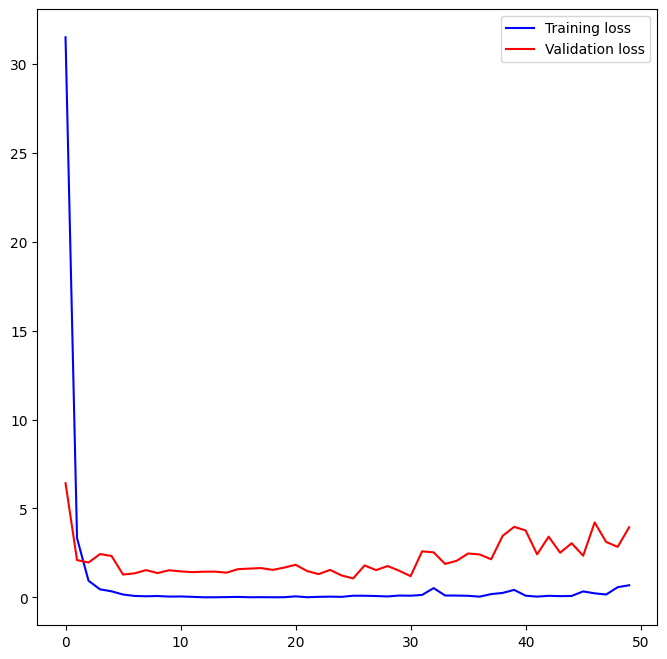

<Figure size 640x480 with 0 Axes>

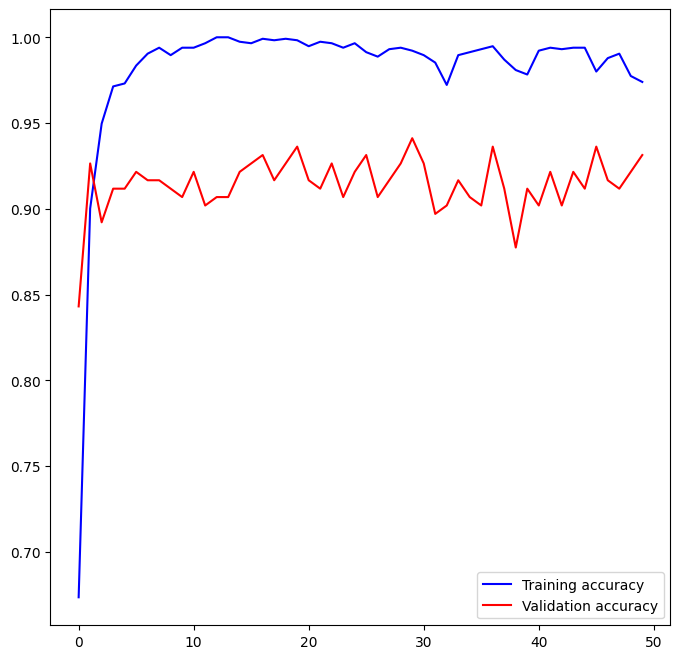

In [9]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

8/8 [==============================] - 3s 183ms/step


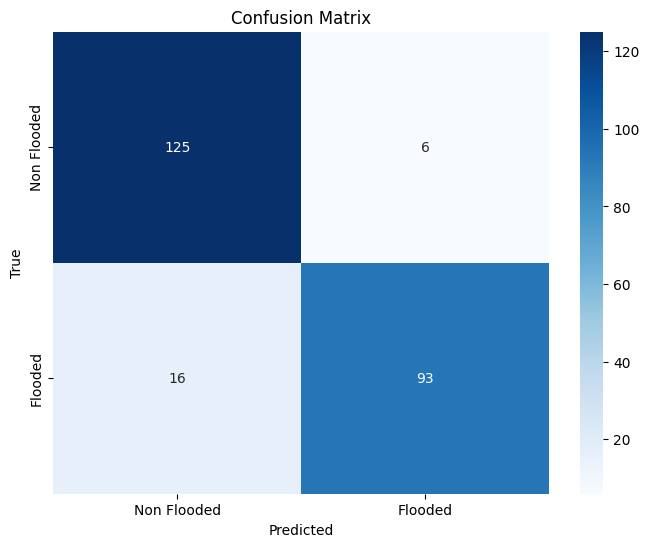

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       131
           1       0.94      0.85      0.89       109

    accuracy                           0.91       240
   macro avg       0.91      0.90      0.91       240
weighted avg       0.91      0.91      0.91       240



In [10]:
test_data_path = os.path.join(data_saved_dir, 'A_preprocessed_data test_images(256, 256).pkl')
test_images, test_labels = load_pickle(test_data_path)

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [11]:
model_saved = r'D:\My Code\Classification\models'
save_pickle(model, os.path.join(model_saved, 'A_InceptionV3 (256X256).pkl'))

INFO:tensorflow:Assets written to: ram://c989c02f-e0bf-4b1e-a734-224532a4e81e/assets


INFO:tensorflow:Assets written to: ram://c989c02f-e0bf-4b1e-a734-224532a4e81e/assets
